# Biome shifts results

This notebook will go through the code necessary to produce figures and results of the biome shifts project. Our primary hypothesis is that rates of character evolution will correlate with rates of turnover (speciation + extinction). We test this looking at transitions between open and closed habitat across several clades of angiosperms. The reasoning for this hypothesis will not be explored here. Instead, we will simply replicate the results and describe the functions being used. 

In [1]:
# ignore this code, this is because my R environments for jupyter differ from rstudio
.libPaths(
  c(.libPaths(), 
    "/home/jboyko/R/x86_64-pc-linux-gnu-library/4.1",
    "/usr/local/lib/R/site-library", 
    "/usr/lib/R/site-library",
    "/usr/lib/R/library")
)

In [44]:
setwd("~/biome_shifts/")
library(ape)
library(hisse)
library(parallel)
library(partitions)
library(ggplot2)
library(dplyr)
library(tidyr)
source("utils.R")

## Model description

The models are broadly partitioned into character-dependent and character-independent models. These models can include hidden states or not. There are 3 types of parameter for which we are concerned, extinction fraction, turnover, and transition rates. These parameters are allowed to vary or can be fixed to remain the same.

### Transition rates

We have 3 states, open habitat $(0,0)$, closed habitat $(1,1)$, widespread $(0,1)$. We structure our model so that no mateter what transitions must occur through the widespread habitat. That is to say: 
$$(0,0)\rightleftarrows(0,1)\rightleftarrows(1,1)$$. 
This is our basic model structure and all parameters will be estiamted freely. The only other factor to consider is whether hidden states are included. To include hidden states, as is necessary for our hypothesis, we add another rate class (A and B): 
$$\left[(0,0;A)\rightleftarrows(0,1;A)\rightleftarrows(1,1; A)\right] \rightleftarrows \left[(0,0;B)\rightleftarrows(0,1;B)\rightleftarrows(1,1; B)\right]$$
Now we have transitions between open, closed, and widespread occuring either in rate class A or rate class B. This forms the basis for how we will test our hypothesis. We are interested in whether there are differences in transition rates between rate classes. AND IF THERE ARE, do those differences tend to correlate with differences in diversification rates. Specifically, if rate class $A$ is faster than $B$, are the diversification dynamics of $A$ also greater than $B$ as expected by our hypothesis? We include a pair of null models to ensure we are not biased to finding support for a difference in transition rates when there is none. This is demonstrated by which parameters are freely estimated. We will include a model that does not have hidden states and two that include hidden states. Of the two that include hidden states, only one will allow for differences in transition rates. Paramerizations look like this):

In [7]:
# make the q_mats
# one rate class
trans.rate <- TransMatMakerMuHiSSE(hidden.traits=0, make.null = TRUE)
trans_rate_1 <- ParDrop(trans.rate, c(2,5,6,8))
# two rate classes
trans.rate <- TransMatMakerMuHiSSE(hidden.traits=1, make.null = FALSE)
trans_rate_2cd <- ParDrop(trans.rate, c(2,5,6,8,10,13,14,16))
trans.rate <- TransMatMakerMuHiSSE(hidden.traits=1, make.null = TRUE)
trans_rate_2cid <- ParDrop(trans.rate, c(2,5,6,8))
trans_rate_2 <- list(trans_rate_2cid, trans_rate_2cd)
print("Q1")
print(trans_rate_1)
print("Q2")
print(trans_rate_2cid)
print("Q3")
print(trans_rate_2cd)

[1] "Q1"
     (00) (01) (10) (11)
(00)   NA    2    0    0
(01)    1   NA    0    4
(10)    0    0   NA    0
(11)    0    3    0   NA
[1] "Q2"
      (00A) (01A) (10A) (11A) (00B) (01B) (10B) (11B)
(00A)    NA     2     0     0     5     0     0     0
(01A)     1    NA     0     4     0     5     0     0
(10A)     0     0    NA     0     0     0     5     0
(11A)     0     3     0    NA     0     0     0     5
(00B)     5     0     0     0    NA     2     0     0
(01B)     0     5     0     0     1    NA     0     4
(10B)     0     0     5     0     0     0    NA     0
(11B)     0     0     0     5     0     3     0    NA
[1] "Q3"
      (00A) (01A) (10A) (11A) (00B) (01B) (10B) (11B)
(00A)    NA     2     0     0     9     0     0     0
(01A)     1    NA     0     4     0     9     0     0
(10A)     0     0    NA     0     0     0     9     0
(11A)     0     3     0    NA     0     0     0     9
(00B)     9     0     0     0    NA     6     0     0
(01B)     0     9     0     0     5   

### Extinction fraction and turnover

The set of models being estimated for fraction and turnover are similar in spirit to the transition rate estimation. Here we will talk directly about which parameters are being estimated. For a single rate class model with 3 observed characters $(0,0), (0,1), (1,1)$ we estimate either all being parameters being equal $par_{free} = (1,1,1)$ or all being different $par_{free} = 1,2,3$. And this can be different for our extinction fraction estimate or turnover. For example, we can have turnover be estimated as constrained while fraction is estimated freely for each observed character:
$$turn_{free} = (1,1,1); ef_{free} = (1,2,3)$$
Another way of saying this is that turnover is character independent (the rates do not depend on which observed state you are in) while extinction fraction is character dependent (the fraction estimate varies depending on which observed state you are in). So if you are in an open habitat, your extinction fraction may be lower or higher than if you wide-spread. We test all possible combinations of this. 

Now let's add hidden states. Essentially we take the above type of thinking and expand it to include multiple rate classes. We can have character dependence in both rate classes, in no rate classes, or in one rate class and not the other. These all have different interpretations depending on the model strucutre. For example, a character independent model with rate heterogenity would look like this:
$$turn_{free} = (1,1,1,2,2,2); ef_{free} = (3,3,3,4,4,4)$$
The first 3 parameters in each vector refer to rate class $A$ and the last 3 refer to rate class $B$. What's important to note is that within each rate class, there is no variation allowed (hence character independent). So whether you are open, closed, or widespread under this framework will have no impact on your diversification dynamics. The diversification dynamics are entirely linked to your rate class. This has typically been discussed as a null hypothesis, but I (JDB) believe that this is a potentially interesting and insightful modeling result. Indeed, our hypothesis is that in cases such as this "null", the rate class with higher turnover rates will also have higher transition rates. This hypothesis cares not for whether the model supports character dependence or independence, it's a direct examinaton of the model parameters.

In [15]:
# single rate class models
ef_1 <- list(c(1,1,0,1),
           c(1,2,0,3))
turn_1 <- list(c(1,1,0,1),
             c(1,2,0,3))

index_1 <- expand.grid(1:length(ef_1), 1:length(turn_1), 1, "1R")

# two rate class models
ef_2 <- list(c(1,1,0,1,1,1,0,1),
             c(1,2,0,3,1,2,0,3),
             c(1,1,0,1,2,2,0,2),
             c(1,2,0,3,4,5,0,6))
turn_2 <- list(c(1,1,0,1,1,1,0,1),
               c(1,2,0,3,1,2,0,3),
               c(1,1,0,1,2,2,0,2),
               c(1,2,0,3,4,5,0,6))

index_2 <- expand.grid(1:length(ef_2), 1:length(turn_2), 1:2, "2R")
print("possible extinction fractions parameterizations - 1 rate class")
print(ef_1)
print("possible turnover parameterizations - 1 rate class")
print(turn_1)
print("possible extinction fractions parameterizations - 2 rate class")
print(ef_2)
print("possible turnover parameterizations - 2 rate class")
print(turn_2)

[1] "possible extinction fractions parameterizations - 1 rate class"
[[1]]
[1] 1 1 0 1

[[2]]
[1] 1 2 0 3

[1] "possible turnover parameterizations - 1 rate class"
[[1]]
[1] 1 1 0 1

[[2]]
[1] 1 2 0 3

[1] "possible extinction fractions parameterizations - 2 rate class"
[[1]]
[1] 1 1 0 1 1 1 0 1

[[2]]
[1] 1 2 0 3 1 2 0 3

[[3]]
[1] 1 1 0 1 2 2 0 2

[[4]]
[1] 1 2 0 3 4 5 0 6

[1] "possible turnover parameterizations - 2 rate class"
[[1]]
[1] 1 1 0 1 1 1 0 1

[[2]]
[1] 1 2 0 3 1 2 0 3

[[3]]
[1] 1 1 0 1 2 2 0 2

[[4]]
[1] 1 2 0 3 4 5 0 6



## Modeling results

I will not go into detail about the model fitting procedure, please refer to 05_run_muhisse for the full code. Instead I will examine the results themselves. Full scripts are (06_*, 07_*, 08_*) which describe in full detail (in code form) the other analyses as well these summarizations.

In [25]:
# load in the models
to_load <- dir("5_results/", full.names = TRUE)
failed_load <- to_load[sapply(to_load, quick_check)]
to_load <- to_load[!sapply(to_load, quick_check)]

all_model_list <- list()
for(i in 1:length(to_load)){
  load(to_load[i])
  all_model_list[[i]] <- res
}

### Hypothesis testing via model support

Clades:\
Let $C$ be the set of clades under consideration.

Models:\
We are considering 36 different models, denoted by $m = 1, 2, \ldots, 36$.

Variables for modeling results:
- Hidden States: $hid_m$ is a binary variable that indicates whether hidden states are included in model $m$. $hid_m = 1$ if hidden states are included, $hid_m = 0$ otherwise.
- Extinction Fraction: $eps_m$ is a binary variable that indicates whether there is a difference in extinction fraction in model $m$. $eps_m = 1$ if there is a difference, $eps_m = 0$ otherwise.
- Turnover: $turn_m$ is a binary variable that indicates whether there is a difference in turnover in model $m$. $turn_m = 1$ if there is a difference, $turn_m = 0$ otherwise.
- Transition Rates: $trans_m$ is a binary variable that indicates whether there is a difference in transition rates in model $m$. $trans_m = 1$ if there is a difference, $trans_m = 0$ otherwise.
- Both Turnover and Transition Rates: $both_m$ is a binary variable that indicates whether there is a difference in both turnover and transition rates in model $m$. $both_m = 1$ if there is a difference, $both_m = 0$ otherwise.

Index Matrix:\
For each model $m$, we create an index matrix $Ind_m$ with dimensions $36 \times 5$ where the elements are either 0 or 1, representing whether the corresponding variables are included in the model. This matrix is defined as:
$$
Ind_m = \begin{pmatrix}
hid_m & epsm & turn_m & trans_m & both_m \\
\vdots & \vdots & \vdots & \vdots & \vdots & \\
\end{pmatrix}
$$

AIC Weights:\
Let $W$ be a table of AIC weights with 51 rows (one for each clade in $C$) and $m = 36$ columns (number of models). $W$ is a matrix of weights.

Result Matrix:\
We multiply the index matrix $Ind_m$ for each model $m$ by the table of AIC weights $W$ to obtain a resulting matrix $Result$ with dimensions $51 \times 5$ where each element represents the sum of model weight for supporting that particular alternative structure. This matrix is defined as:
$$
Result = \begin{pmatrix}
w_{1,1} & w_{1,2} & w_{1,3} & w_{1,4} & w_{1,5} \\
w_{2,1} & w_{2,2} & w_{2,3} & w_{2,4} & w_{2,5} \\
\vdots & \vdots & \vdots & \vdots & \vdots \\
w_{51,1} & w_{51,2} & w_{51,3} & w_{51,4} & w_{51,5} \\
\end{pmatrix}
$$

Where $w_{ij}$ represents the sum of model weights for supporting the $i$-th clade and the $j$-th alternative structure. Note that $w_{ij}$ is calculated as the dot product of the $i$-th row of $W$ and the $j$-th column of $Ind_m$.


In [40]:
# some labeling
n_tips <- unlist(lapply(all_model_list, function(x) Ntip(x[[1]]$phy)))
clade_names <- unlist(lapply(strsplit(to_load, "results_"), function(x) gsub(".RData", "", x[2])))
clade_names <- unlist(lapply(strsplit(clade_names, "-"), function(x) x[[1]]))
clade_names <- unlist(lapply(strsplit(clade_names, "_"), function(x) x[[1]]))
clade_names <- paste0(clade_names, " (", n_tips, ")")
# the calculation
aic_table <- do.call(rbind, lapply(all_model_list, GetAICWeights))
which_models <- do.call(rbind, lapply(all_model_list[[1]], test_hypotheses))
result_matrix <- aic_table %*% which_models
rownames(result_matrix) <- clade_names
head(result_matrix)

,hidden_incl,eps_differ,turn_differ,trans_differ,both_differ
Allium (309),0.9999811,9.182384e-01,0.9983330,0.22717791,0.225646787
Alysseae (60),0.4108631,1.149567e-01,0.1031750,0.01095342,0.004533091
Anarcardiaceae (250),0.9999190,1.928950e-02,0.9937156,0.82282799,0.817586966
Annonaceae (188),1.0000000,6.058675e-01,0.5773250,0.23709421,0.110610693
Antirrhineae (191),0.9999976,2.792860e-01,0.9734011,0.57721470,0.575358984
Apioideae (847),1.0000000,4.799396e-05,0.9999994,0.99999432,0.999993703


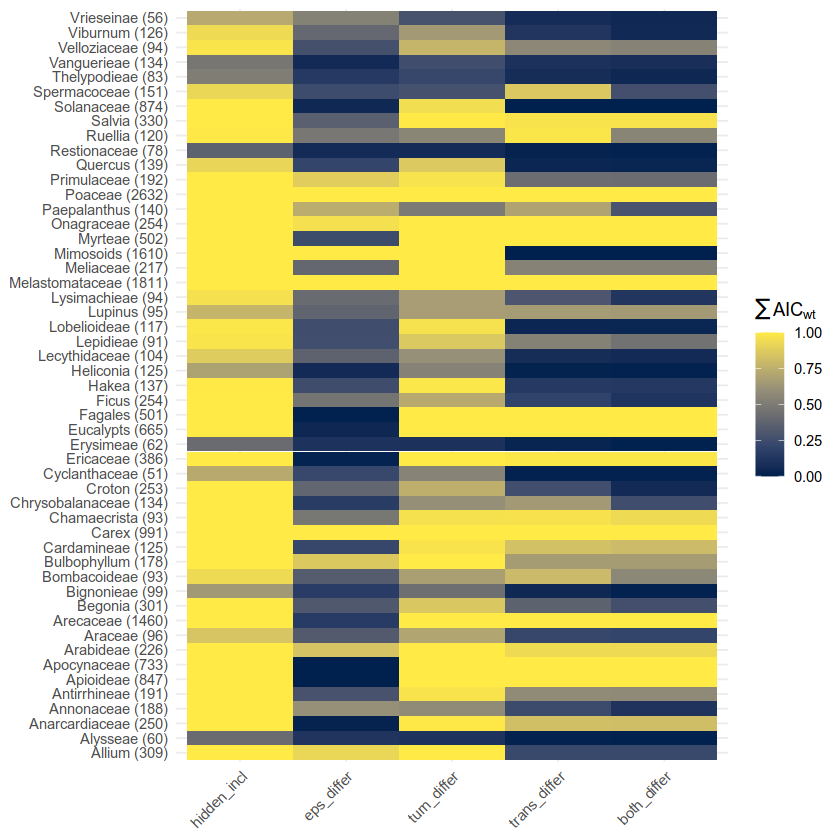

In [43]:
# Add row names as a column
result_matrix <- as.data.frame(result_matrix)
result_matrix$RowNames <- rownames(result_matrix)
# Reshape the data from wide to long format
result_matrix_long <- result_matrix %>%
  pivot_longer(cols = -RowNames, names_to = "Variable", values_to = "Value")
result_matrix_long$Variable <- factor(result_matrix_long$Variable, unique(result_matrix_long$Variable))
# Create the heatmap
#D01B1B, #FF4242, #FFFFFF, #e7f9ff, #95D2EC and #47abd8. 
p <- ggplot(result_matrix_long, aes(x = Variable, y = RowNames, fill = Value)) +
  geom_tile() +
  scale_fill_viridis_c(option = "E", name = expression(sum(AIC[wt]))) +
  labs(x = NULL, y = NULL) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))
print(p)

### Where there is variation, do we find support?

Here we will examine when there is support for both_differ ($AIC_{wt} > 0.5$)